In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#read train image with CV
train_dir = '/data/tmpexec/ecg/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/tmpexec/ecg/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [3]:
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),20000))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
assert (trQ_sf.shape==trP_sf.shape)
assert (trQ_sf.shape==trN_sf.shape)

20000 / 20000 

In [10]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHNet(nn.Module):
    def __init__(self, hash_size: int, class_size:int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.hash = nn.Sequential(
            nn.Linear(16*128*128, hash_size),
            nn.ReLU(inplace=True)
            #nn.Sigmoid()
            #nn.Tanh()
        )
        self.classes = nn.Linear(hash_size, class_size)
        
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x_hash = self.hash(x)
        x_class = self.classes(x_hash)
        return x_hash,x_class

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py   
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
        
#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)

In [15]:
#define model
model = ASHNet(hash_size=36, class_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer

#define FocalLoss gamma=[0,0.5,1,2,5] alpha=[0.25,0.25,0.25,0.25,0.25]
criterion  = FocalLoss(gamma=2).cuda() 
#train model with focal loss
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        X_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(trY[min_idx:max_idx])).type(torch.LongTensor).cuda()
        #forword
        _, out_class = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #binary-like loss
        loss = criterion(out_class, y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#train model with triplet loss
criterion  = TripletLoss(margin=0.5).cuda() #define pairwise loss
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(trQ_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(trP_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(trN_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash, _ = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, _ = model(P_batch.permute(0, 3, 1, 2))
        N_hash, _ = model(N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

 2000 / 2000 : loss = 0.014966Eopch:     1 mean_loss = 0.089737
 2000 / 2000 : loss = 0.003948Eopch:     2 mean_loss = 0.021633
 2000 / 2000 : loss = 0.028069Eopch:     3 mean_loss = 0.010420
 2000 / 2000 : loss = 0.000411Eopch:     4 mean_loss = 0.008388
 2000 / 2000 : loss = 5.6e-054Eopch:     5 mean_loss = 0.004036
 2000 / 2000 : loss = 0.013773Eopch:     6 mean_loss = 0.003952
 2000 / 2000 : loss = 5.5e-051Eopch:     7 mean_loss = 0.003601
 2000 / 2000 : loss = 2e-06164Eopch:     8 mean_loss = 0.001086
 2000 / 2000 : loss = 0.000394Eopch:     9 mean_loss = 0.004103
 2000 / 2000 : loss = 1.4e-057Eopch:    10 mean_loss = 0.001012
best_loss = 0.001012
 2000 / 2000 : loss = 0.0194866Eopch:     1 mean_loss = 0.633161
 2000 / 2000 : loss = 0.1601597Eopch:     2 mean_loss = 0.085518
 2000 / 2000 : loss = 0.0639379Eopch:     3 mean_loss = 0.067639
 2000 / 2000 : loss = 0.044612Eopch:     4 mean_loss = 0.086150
 2000 / 2000 : loss = 0.066019Eopch:     5 mean_loss = 0.038407
 2000 / 2000 : l

In [16]:
#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance with hash
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

#performance with class
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    X_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    _, out_class = best_net(X_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_class.cpu().data.numpy().tolist()) #record feature
    out_class = F.log_softmax(out_class,dim=1) 
    pred = out_class.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

 1999 / 2000 Completed buliding index in 1 seconds
Accuracy: 0.773350
[[11757   239  2781    69     0]
 [  403   305   235     1     0]
 [  343    35  3401     9     0]
 [  335     0    75     4     0]
 [    4     0     4     0     0]]
Specificity: 0.791930
Sensitivity of S: 0.323093
Sensitivity of V: 0.897835
Sensitivity of F: 0.009662
Sensitivity of Q: 0.000000
 1999 / 2000 Accuracy: 0.691900
[[10143  2066  2577    60     0]
 [  238   510   196     0     0]
 [  310   286  3183     9     0]
 [  338    11    63     2     0]
 [    4     0     4     0     0]]
Specificity: 0.683214
Sensitivity of S: 0.540254
Sensitivity of V: 0.840285
Sensitivity of F: 0.004831
Sensitivity of Q: 0.000000


Org data dimension is 5.Embedded data dimension is 2


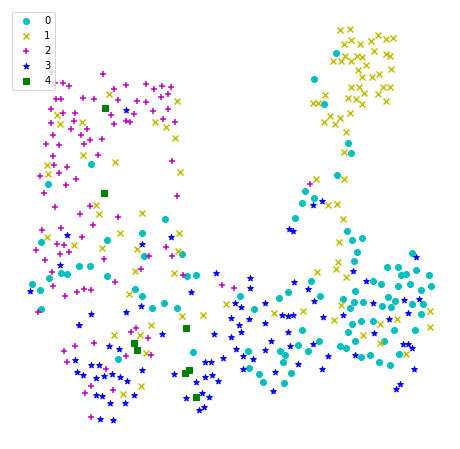

In [17]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()[0:100]
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()[0:100]
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()[0:100]
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()[0:100]
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

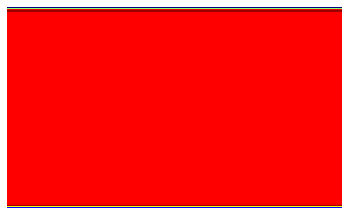

In [18]:
#feature map
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
 
# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

image_path = '/data/tmpexec/ecg/test/9929-2.png' #V:Ventricular ectopic beat
oriImg = cv2.imread(image_path)
height, width, _ = oriImg.shape
#plt.axis('off')
#plt.imshow(oriImg)
data = []
oriImg = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))
data.append(oriImg)
data = torch.from_numpy(np.array(data)).type(torch.FloatTensor).cuda() 

activation = {}
best_net.sa.register_forward_hook(get_activation('sa'))#spatial attention
output = best_net(data.permute(0, 3, 1, 2))
feature = activation['sa'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
plt.axis('off')
plt.imshow(featuremap)

In [8]:
#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_hash, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_hash = X_hash.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_hash.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance with hash
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 1999 / 2000 Completed buliding index in 24 seconds
mHR@5=0.767000, mAP@5=0.755568, mRR@5=0.969637
mHR@10=0.767155, mAP@10=0.752808, mRR@10=0.959251
mHR@15=0.766840, mAP@15=0.751467, mRR@15=0.952275
mHR@20=0.766660, mAP@20=0.750577, mRR@20=0.948231
 1999 / 2000 Accuracy: 0.619650
[[8303 1254 4892  397    0]
 [ 149  350  430   15    0]
 [  26   10 3687   65    0]
 [ 165    8  188   53    0]
 [   0    2    6    0    0]]
Specificity: 0.559275
Sensitivity of S: 0.370763
Sensitivity of V: 0.973337
Sensitivity of F: 0.128019
Sensitivity of Q: 0.000000


In [18]:
#test network: valid
xq = torch.rand(10,3,256,256).cuda()
xp = torch.rand(10,3,256,256).cuda()
xn = torch.rand(10,3,256,256).cuda()
model = ASHNet(hash_size=36, class_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define pairwise loss
for epoch in range(10):
    optimizer.zero_grad()
    
    outq,_ = model(xq)#out.grad_fn
    outp,_ = model(xp)
    outn,_ = model(xn)
    loss = criterion(outq,outp,outn)
    print (loss.item())
    loss.backward()
    optimizer.step()
    #observe the variant of model.parameters
    for i in model.named_parameters():
        print(i[0])
        print(i[1][0][0][0])
        break
#output
x = torch.rand(10,3,256,256).cuda()
out,_ = model(x)
#out = torch.sign(out) #Binarization,[-1,1]->{-1,1}
print (out.size())
x = x.cpu()
xq = xq.cpu()
xp = xp.cpu()
xn = xn.cpu()
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()

18.000080108642578
net.0.net.0.weight
tensor([0.1009, 0.1183, 0.0598], device='cuda:0', grad_fn=<SelectBackward>)
17.973249435424805
net.0.net.0.weight
tensor([0.1016, 0.1175, 0.0605], device='cuda:0', grad_fn=<SelectBackward>)
17.716821670532227
net.0.net.0.weight
tensor([0.1024, 0.1167, 0.0607], device='cuda:0', grad_fn=<SelectBackward>)
17.584300994873047
net.0.net.0.weight
tensor([0.1027, 0.1160, 0.0608], device='cuda:0', grad_fn=<SelectBackward>)
17.504169464111328
net.0.net.0.weight
tensor([0.1026, 0.1154, 0.0610], device='cuda:0', grad_fn=<SelectBackward>)
17.44349479675293
net.0.net.0.weight
tensor([0.1025, 0.1150, 0.0611], device='cuda:0', grad_fn=<SelectBackward>)
17.424943923950195
net.0.net.0.weight
tensor([0.1025, 0.1145, 0.0611], device='cuda:0', grad_fn=<SelectBackward>)
17.4094181060791
net.0.net.0.weight
tensor([0.1024, 0.1139, 0.0610], device='cuda:0', grad_fn=<SelectBackward>)
17.38896369934082
net.0.net.0.weight
tensor([0.1023, 0.1132, 0.0609], device='cuda:0', grad